<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/vgg19%2Bgaussian%2Bprewitt_final_80_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.applications import VGG19

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Final Thesis/Feature Extraction/Prewitt edge detection/prewitt+gaussian",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7471 files belonging to 5 classes.


In [ ]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro', '_Healthy']


234

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 4 3 2 4 4 0 4 0 2 3 2 2 2 1 0 0 2 1 3 2 3 0 4 2 0 3 4 0 4 4]


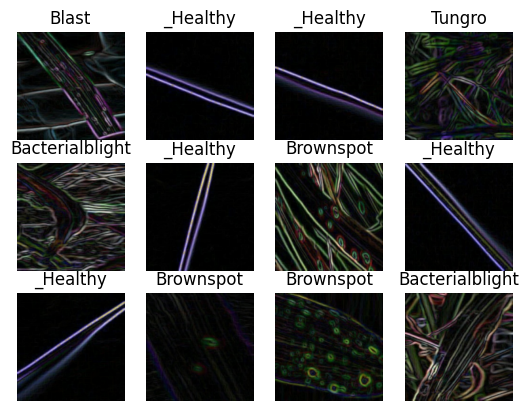

In [ ]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split +  val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

163
23
48


In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Determine the number of classes in your dataset
n_classes = len(class_names)

# Create the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Reducing neuron count
model.add(Dropout(0.5))  # Adding dropout
model.add(Dense(64, activation='relu'))   # Reducing neuron count
model.add(Dropout(0.5))  # Adding dropout
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
base_model.trainable=False

In [ ]:
# Display the VGG16 model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_14 (Flatten)        (None, 32768)             0         
                                                                 
 dense_32 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 5)               

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,

    epochs=25,
)

Epoch 1/25
163/163 [==============================] - 59s 288ms/step - loss: 2.4055 - accuracy: 0.5045 - val_loss: 0.9891 - val_accuracy: 0.6078
Epoch 2/25
163/163 [==============================] - 35s 217ms/step - loss: 1.1727 - accuracy: 0.5630 - val_loss: 0.8341 - val_accuracy: 0.6287
Epoch 3/25
163/163 [==============================] - 35s 217ms/step - loss: 1.0622 - accuracy: 0.5822 - val_loss: 0.5820 - val_accuracy: 0.7038
Epoch 4/25
163/163 [==============================] - 35s 216ms/step - loss: 0.8612 - accuracy: 0.6192 - val_loss: 0.5391 - val_accuracy: 0.7163
Epoch 5/25
163/163 [==============================] - 35s 217ms/step - loss: 0.7826 - accuracy: 0.6445 - val_loss: 0.4991 - val_accuracy: 0.8317
Epoch 6/25
163/163 [==============================] - 35s 216ms/step - loss: 0.7652 - accuracy: 0.6669 - val_loss: 0.4067 - val_accuracy: 0.8595
Epoch 7/25
163/163 [==============================] - 35s 216ms/step - loss: 0.7260 - accuracy: 0.6690 - val_loss: 0.4135 - val_ac

In [ ]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 20s 196ms/step - loss: 0.3009 - accuracy: 0.9225


In [ ]:
scores

[0.3009469211101532, 0.9225260615348816]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

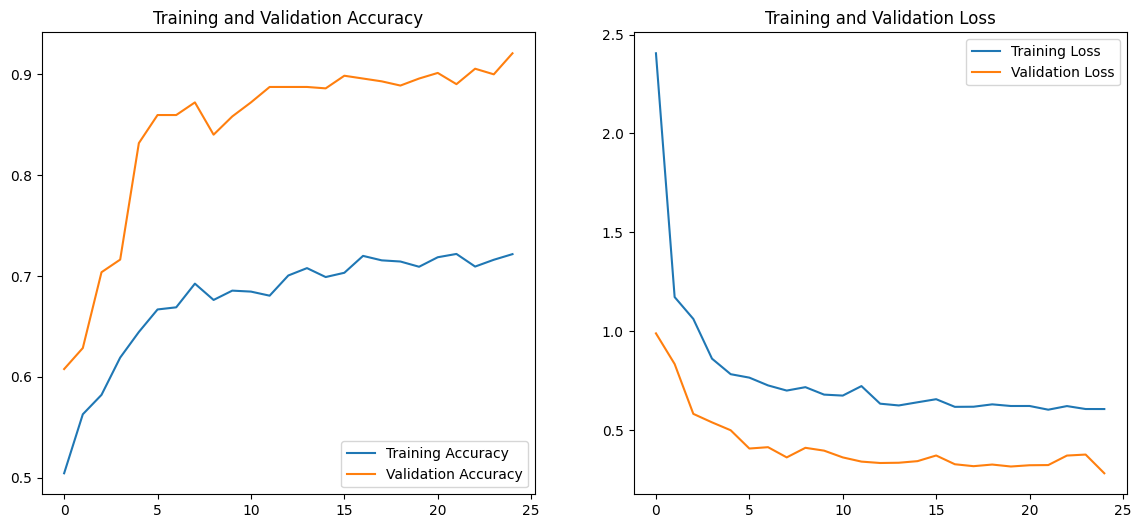

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blast
1/1 [==============================] - 0s 172ms/step
predicted label: Blast


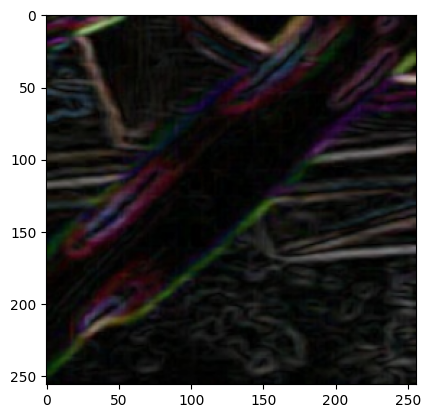

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

48/48 [==============================] - 9s 188ms/step


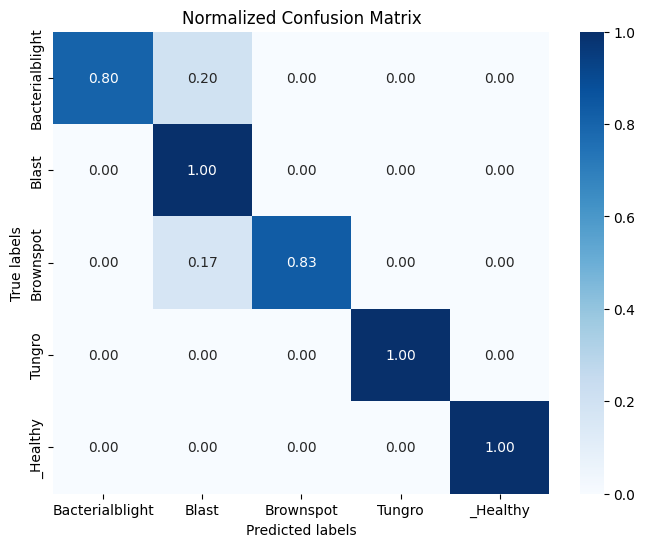

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = class_names
report = classification_report(test_labels, predicted_labels, target_names=target_names)

print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       1.00      0.80      0.89       309
          Blast       0.73      1.00      0.85       327
      Brownspot       1.00      0.83      0.91       327
         Tungro       1.00      1.00      1.00       273
       _Healthy       1.00      1.00      1.00       300

       accuracy                           0.92      1536
      macro avg       0.95      0.92      0.93      1536
   weighted avg       0.94      0.92      0.92      1536

